In [1]:
import os
import pickle
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from ai.ml.knn.inference import knn_inference
from ai.ml.knn.evaluation import evaluate

In [2]:
TENANT_ID = "77b67978-ae76-4480-ac96-066ea269541e"
TABLE_NAME = "cashrec_cashpaid"
SERVICE = "account_mapping"

# Loading Model Selection

In [16]:
model_selection_timestamp = "2025-05-07-07-37-57"
model_selection_dir = f"/Users/amirhossein/Projects/bookiewand/ai/data/{SERVICE}/model_selection/{TENANT_ID}/{model_selection_timestamp}/{TABLE_NAME}"

In [17]:
with open(os.path.join(model_selection_dir, 'cv_results.json'), 'r') as handle:
    cv_results = json.load(handle)
with open(os.path.join(model_selection_dir, 'cv_best_minimal_config.json'), 'r') as handle:
    cv_best_minimal_config = json.load(handle)
with open(os.path.join(model_selection_dir, 'hyperparameters.json'), 'r') as handle:
    cv_hyperparameters = json.load(handle)
cv_df = pd.read_csv(os.path.join(model_selection_dir, 'df.csv'))

# Loading Train

In [18]:
train_timestamp = "2025-05-07-09-47-14"
train_checkpoints_dir = f"/Users/amirhossein/Projects/bookiewand/ai/data/{SERVICE}/checkpoints/{TENANT_ID}/{train_timestamp}/{TABLE_NAME}"

In [19]:
with open(os.path.join(train_checkpoints_dir, 'encoders.pkl'), 'rb') as handle:
    train_encoders = pickle.load(handle)
with open(os.path.join(train_checkpoints_dir, 'hyperparameters.json'), 'r') as handle:
    train_hyperparameters = json.load(handle)
with open(os.path.join(train_checkpoints_dir, 'model.pkl'), 'rb') as handle:
    knn_model = pickle.load(handle)
train_df = pd.read_csv(os.path.join(train_checkpoints_dir, 'train.csv'))

In [23]:
model_data = {
    "encoders": train_encoders,
    "hyperparameters": train_hyperparameters,
    "train_df": train_df,
    "knn_model": knn_model,
}

In [41]:
print("[*] target_variable: ", train_hyperparameters["target_variable"])
print("[*] numerical_features: ", train_hyperparameters["numerical_features"])
print("[*] categorical_features: ", train_hyperparameters["categorical_features"])
print("[*] n_neighbors: ", train_hyperparameters["n_neighbors"])
print("[*] weights: ", train_hyperparameters["weights"])
print("[*] X_train.shape: ", train_hyperparameters["X.shape"])
print("[*] y_train.shape: ", train_hyperparameters["y.shape"])

[*] target_variable:  account_code
[*] numerical_features:  ['journal_line_net_amount', 'bank_transaction_total_tax']
[*] categorical_features:  ['bank_transaction_line_description', 'journal_reference', 'bank_account_name', 'bank_transaction_contact_name']
[*] n_neighbors:  5
[*] weights:  distance
[*] X_train.shape:  [8410, 2659]
[*] y_train.shape:  [8410]


# Loading Eval Data

In [20]:
raw_data_timestamp = "2025-05-07-09-47-14"
raw_data_dir = f"/Users/amirhossein/Projects/bookiewand/ai/data/{SERVICE}/raw/{raw_data_timestamp}/{TABLE_NAME}"
raw_df = pd.read_csv(os.path.join(raw_data_dir, f"{TENANT_ID}.csv"))

# Running Inference on Eval Data

In [24]:
# calling the knn inference over the raw df
response = knn_inference(tenant_id=TENANT_ID,
                         table_name=TABLE_NAME,
                         df=raw_df,
                         model_data=model_data)

[*] 2025-05-07 13:57:42 - INFO - Running KNN inference for tenant: 77b67978-ae76-4480-ac96-066ea269541e
[*] 2025-05-07 13:57:42 - INFO - Converted target variable to string and replaced specified missing values.
[*] 2025-05-07 13:57:42 - INFO - Found 0 missing values in target variable 'account_code'.
[*] 2025-05-07 13:57:42 - INFO - Filled missing values in target variable 'account_code' with 'NOT_APPLICABLE'.
[*] 2025-05-07 13:57:42 - INFO - Final unique values in account_code: ['60830' '60210' '44000' '30700' '60510' '804' '61210' '60311' '60110'
 '21002' '60810' '61260' '61250' '25500' '21007' '21005' '60808' '60809'
 '60310' '61910' '60451' '40002' '20300' '61685' '17200' '61010' '63050'
 '62020' '61681' '21017' '61630' '61510' '60605' '60710' '60651' '63070'
 '61955' '61240' '61310' '61909' '68002' '21011' '21997' '69001' '48000'
 '61020' '40001' '61220' '60500' '21999' '61030' '28003' '30701' '28005'
 '28004' '60610' '62010' '61690' '10105' '21100' '51009' '51005' '60465'
 '1018

In [26]:
# computing the evaluation results dataframe
results_df = evaluate(response=response)

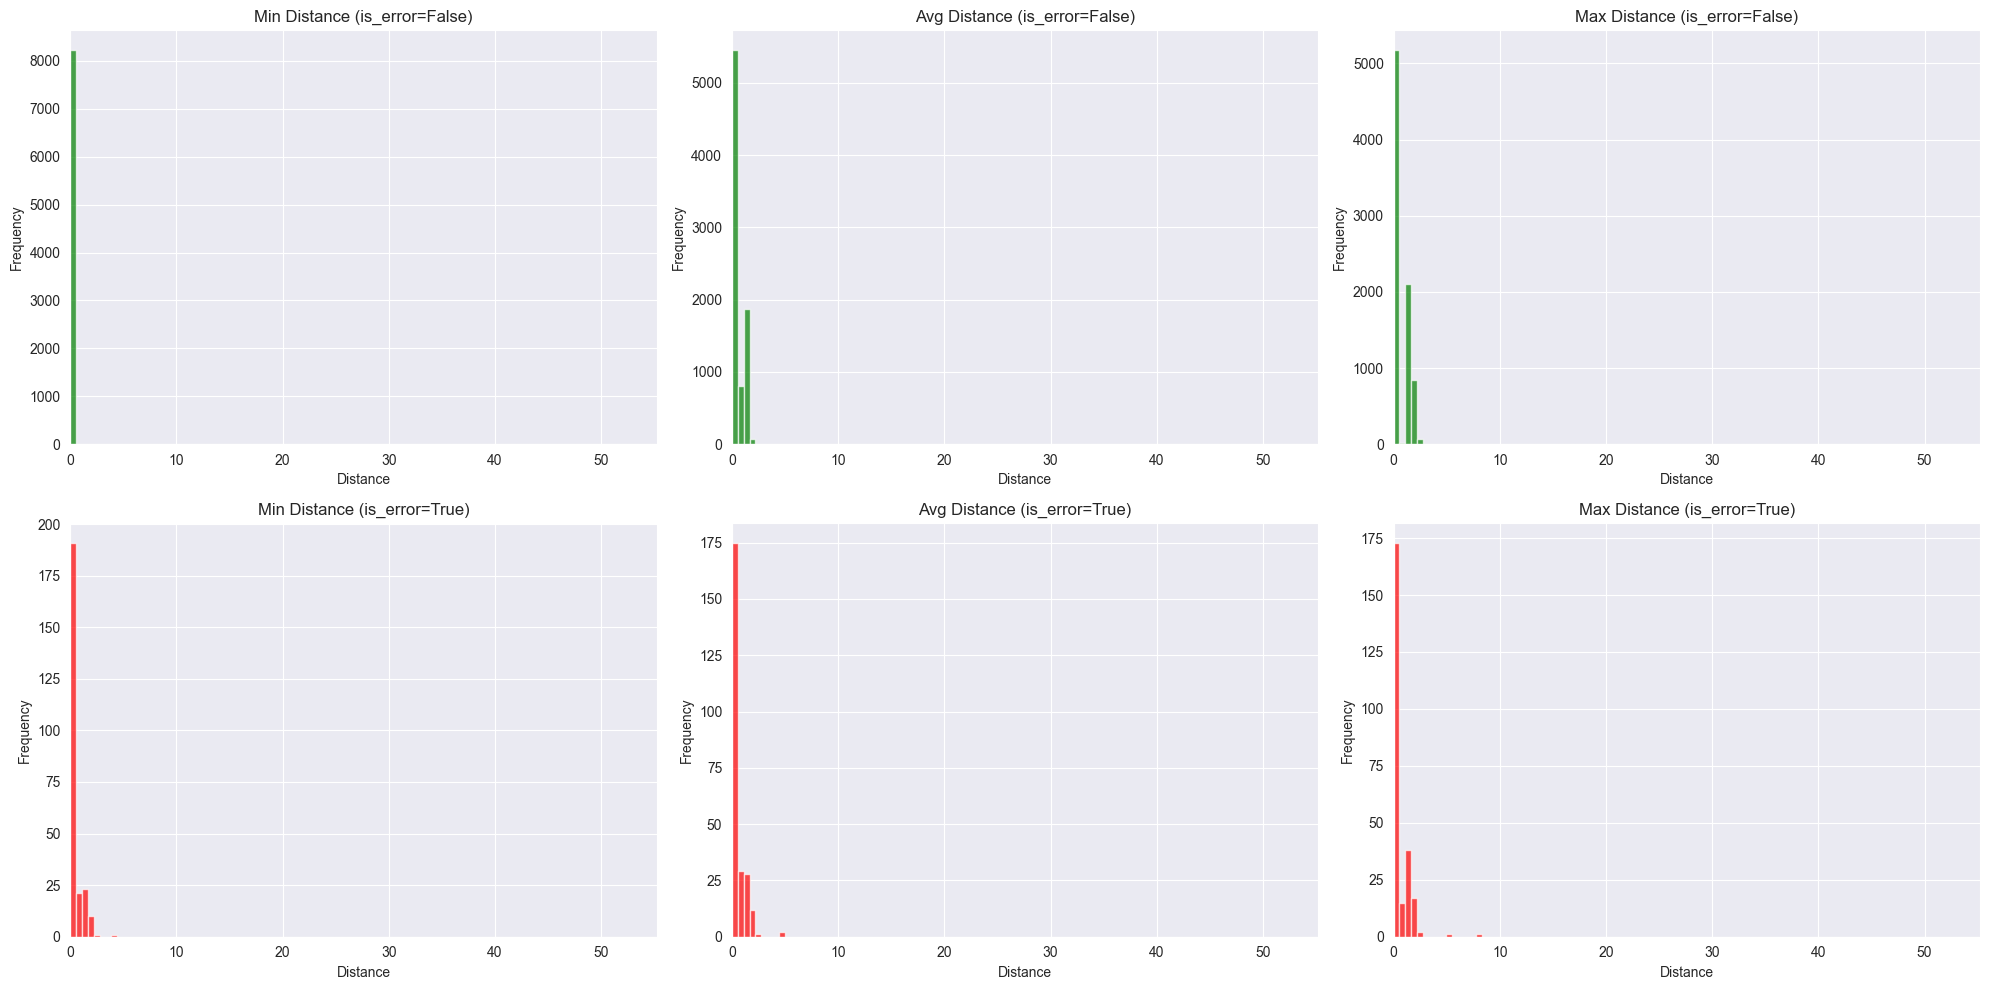

In [31]:
# plotting histogram of distances to neighbors for correct and wrong prediction

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

axes[0, 0].set_title('Min Distance (is_error=False)')
axes[0, 1].set_title('Avg Distance (is_error=False)')
axes[0, 2].set_title('Max Distance (is_error=False)')  # New title
axes[1, 0].set_title('Min Distance (is_error=True)')
axes[1, 1].set_title('Avg Distance (is_error=True)')
axes[1, 2].set_title('Max Distance (is_error=True)')  # New title

min_x = min(results_df['min_distance'].min(), results_df['avg_distance'].min(), results_df['max_distance'].min())
max_x = max(results_df['min_distance'].max(), results_df['avg_distance'].max(), results_df['max_distance'].max())

false_results = results_df[results_df['is_error'] == False]
true_results = results_df[results_df['is_error'] == True]

bins = np.linspace(min_x, max_x, 101)

axes[0, 0].hist(false_results['min_distance'], bins=bins, alpha=0.7, color='green')
axes[0, 1].hist(false_results['avg_distance'], bins=bins, alpha=0.7, color='green')
axes[0, 2].hist(false_results['max_distance'], bins=bins, alpha=0.7, color='green')  # New plot

axes[1, 0].hist(true_results['min_distance'], bins=bins, alpha=0.7, color='red')
axes[1, 1].hist(true_results['avg_distance'], bins=bins, alpha=0.7, color='red')
axes[1, 2].hist(true_results['max_distance'], bins=bins, alpha=0.7, color='red')  # New plot

for ax in axes.flatten():
    ax.set_xlim(min_x, max_x)
    ax.set_xlabel('Distance')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [42]:
# computing the accuracy
accuracy = 1 - len(results_df[results_df["is_error"]]) / len(results_df)
print("[*] Evaluation accuracy:", accuracy)

[*] Evaluation accuracy: 0.9708382526564345


In [33]:
# Confusion matrix
cm = confusion_matrix(
    y_true=results_df['ground_truth'],
    y_pred=results_df['prediction']
)

In [98]:
# Check the shape of the confusion matrix
print(f"Confusion matrix shape: {cm.shape}")

# Calculate precision, recall, and accuracy for each class
unique_classes = np.unique(results_df['ground_truth'])
n_classes = len(results_df['ground_truth'].unique())
metrics_data = []

total_samples = cm.sum()
class_samples = np.sum(cm, axis=1)  # Sum of rows gives total samples per class

for i in range(n_classes):
    # get the ground-truth class label
    gt_label = unique_classes[i]
    num_gt_labels_in_raw_df = len(raw_df[raw_df['account_code'] == gt_label])
    num_gt_labels_in_train_df = len(train_df[train_df['account_code'] == int(gt_label)])

    # True positives: diagonal element
    tp = cm[i, i]

    # False positives: sum of column i - true positives
    fp = cm[:, i].sum() - tp

    # False negatives: sum of row i - true positives
    fn = cm[i, :].sum() - tp

    # True negatives: sum of all values - (tp + fp + fn)
    tn = total_samples - (tp + fp + fn)

    # Number of samples in this class
    samples = class_samples[i]

    # Percentage of samples
    samples_percentage = (samples / total_samples) * 100

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / total_samples

    metrics_data.append({
        'class': gt_label,
        'class_name': raw_df[raw_df['account_code'] == gt_label]['account_name'].unique()[0],
        'num_samples_in_eval': num_gt_labels_in_raw_df,
        'pct_in_eval (%)': samples_percentage,
        'num_samples_in_train': num_gt_labels_in_train_df,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    })

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics_data)

# Calculate weighted macro averages
weighted_precision = np.average(metrics_df['precision'], weights=metrics_df['num_samples_in_eval'])
weighted_recall = np.average(metrics_df['recall'], weights=metrics_df['num_samples_in_eval'])
weighted_accuracy = np.average(metrics_df['accuracy'], weights=metrics_df['num_samples_in_eval'])

# Calculate simple macro averages
macro_precision = metrics_df['precision'].mean()
macro_recall = metrics_df['recall'].mean()
macro_accuracy = metrics_df['accuracy'].mean()

# Add macro and weighted averages to the DataFrame
summary_metrics_df = pd.concat([
    pd.DataFrame([{
        'class': 'Macro Avg',
        'class_name': None,
        'num_samples_in_eval': total_samples,
        'pct_in_eval (%)': metrics_df['pct_in_eval (%)'].sum(),
        'num_samples_in_train': metrics_df['num_samples_in_train'].sum(),
        'precision': macro_precision,
        'recall': macro_recall,
        'accuracy': macro_accuracy
    }]),
    pd.DataFrame([{
        'class': 'Weighted Avg',
        'class_name': None,
        'num_samples_in_eval': total_samples,
        'pct_in_eval (%)': metrics_df['pct_in_eval (%)'].sum(),
        'num_samples_in_train': metrics_df['num_samples_in_train'].sum(),
        'precision': weighted_precision,
        'recall': weighted_recall,
        'accuracy': weighted_accuracy
    }])
], ignore_index=True)

# Calculate overall accuracy (global accuracy)
overall_accuracy = (np.trace(cm) / total_samples).item()

Confusion matrix shape: (73, 73)


In [99]:
overall_accuracy

0.9708382526564344

In [100]:
metrics_df

,class,class_name,num_samples_in_eval,pct_in_eval (%),num_samples_in_train,TP,FP,TN,FN,precision,recall,accuracy
0,10105,APS Investment Account,44,0.519481,44,44,1,8425,0,0.977778,1.0,0.999882
1,10181,Unidentified Deposits,1,0.011806,0,0,0,8469,1,0.000000,0.0,0.999882
2,17200,Plant & Equipment,6,0.070838,6,6,0,8464,0,1.000000,1.0,1.000000
3,17300,Office Furniture & Equipment,1,0.011806,0,0,0,8469,1,0.000000,0.0,0.999882
4,17900,Leasehold improvements,2,0.023613,0,0,0,8468,2,0.000000,0.0,0.999764
...,...,...,...,...,...,...,...,...,...,...,...,...
68,63050,Travel - Toll Fees,28,0.330579,28,28,0,8442,0,1.000000,1.0,1.000000
69,63070,Sub Contract Labour,4,0.047226,0,0,0,8466,4,0.000000,0.0,0.999528
70,68002,Casual Wages,92,1.086187,92,92,2,8376,0,0.978723,1.0,0.999764
71,69001,Workers Comp Insurance,1,0.011806,0,0,0,8469,1,0.000000,0.0,0.999882


In [101]:
summary_metrics_df

,class,class_name,num_samples_in_eval,pct_in_eval (%),num_samples_in_train,precision,recall,accuracy
0,Macro Avg,None,8470,100.0,8410,0.597659,0.609615,0.999201
1,Weighted Avg,None,8470,100.0,8410,0.964512,0.970838,0.992780


In [104]:
error_groups = results_df[results_df['is_error'] == True].groupby(['prediction', 'ground_truth'])

# 3. Calculate error count and validate class_frequency
error_analysis = []
for (pred, truth), group in error_groups:
    # Check if class_frequency has more than one unique value
    unique_frequencies = group['class_frequency'].unique()
    if len(unique_frequencies) > 1:
        raise ValueError(f"Multiple class_frequency values found for prediction={pred}, ground_truth={truth}")

    # Create a record for this error group
    error_analysis.append({
        'prediction': pred,
        'prediction_name': raw_df[raw_df['account_code'] == pred]['account_name'].unique().item(),
        'ground_truth': truth,
        'ground_truth_name': raw_df[raw_df['account_code'] == truth]['account_name'].unique().item(),
        'error_count': len(group),
        'class_frequency': unique_frequencies[0]
    })

# Convert to DataFrame and sort by error count
error_df = pd.DataFrame(error_analysis)
error_df = error_df.sort_values('error_count', ascending=False).reset_index(drop=True)

In [105]:
error_df

,prediction,prediction_name,ground_truth,ground_truth_name,error_count,class_frequency
0,21997,Loan - Tim & Sara McLeod,30701,Tim - Personal Drawings,79,11.36
1,30701,Tim - Personal Drawings,21997,Loan - Tim & Sara McLeod,60,28.36
2,60310,Computer Software and Licences,60311,Computer Software Support,22,1.09
3,21999,Loan - NA & SE McLeod,30700,Neil - Personal Drawings,10,5.16
4,30700,Neil - Personal Drawings,21999,Loan - NA & SE McLeod,7,7.80
5,60808,Interest - ANZ Bank Loan - Ford,60810,Interest - Esanda Contract,4,0.00
6,21007,ANZ CM Loan - Ford Everest,21002,Esanda Loan - iLoad (Current),4,0.00
7,30700,Neil - Personal Drawings,60451,Charities & Donations,3,0.00
8,61909,Rubbish Removal & Cleaning,61910,Sundry Expenses,3,0.51
9,61630,Printing & Stationery,51005,Plastic Wrap,3,0.00


In [118]:
num_nans_in_error = {
    "prediction": [],
    "prediction_name": [],
    "ground_truth": [],
    "ground_truth_name": [],
    "is_error": [],
    "num_nan_features": []

}
features = train_hyperparameters["numerical_features"] + train_hyperparameters["categorical_features"]
for res in response.results:
    prediction = res.target_prediction
    prediction_name = raw_df[raw_df['account_code'] == prediction]['account_name'].unique().item()
    ground_truth = res.user_class
    ground_truth_name = raw_df[raw_df['account_code'] == ground_truth]['account_name'].unique().item()
    is_error = ground_truth != prediction
    num_nan_features = pd.Series(res.record.model_dump())[features].isna().sum()

    num_nans_in_error["prediction"].append(prediction)
    num_nans_in_error["prediction_name"].append(prediction_name)
    num_nans_in_error["ground_truth"].append(ground_truth)
    num_nans_in_error["ground_truth_name"].append(ground_truth_name)
    num_nans_in_error["is_error"].append(is_error)
    num_nans_in_error["num_nan_features"].append(num_nan_features)
num_nans_in_error = pd.DataFrame.from_dict(num_nans_in_error)

In [119]:
num_nans_in_error

,prediction,prediction_name,ground_truth,ground_truth_name,is_error,num_nan_features
0,60830,Interest - Credit Card,60830,Interest - Credit Card,False,1
1,60210,Bank Fees & Charges,60210,Bank Fees & Charges,False,2
2,60210,Bank Fees & Charges,60210,Bank Fees & Charges,False,2
3,44000,Interest Received,44000,Interest Received,False,1
4,30700,Neil - Personal Drawings,30700,Neil - Personal Drawings,False,2
...,...,...,...,...,...,...
8465,21997,Loan - Tim & Sara McLeod,21997,Loan - Tim & Sara McLeod,False,2
8466,21997,Loan - Tim & Sara McLeod,21997,Loan - Tim & Sara McLeod,False,2
8467,21997,Loan - Tim & Sara McLeod,21997,Loan - Tim & Sara McLeod,False,2
8468,21997,Loan - Tim & Sara McLeod,21997,Loan - Tim & Sara McLeod,False,2


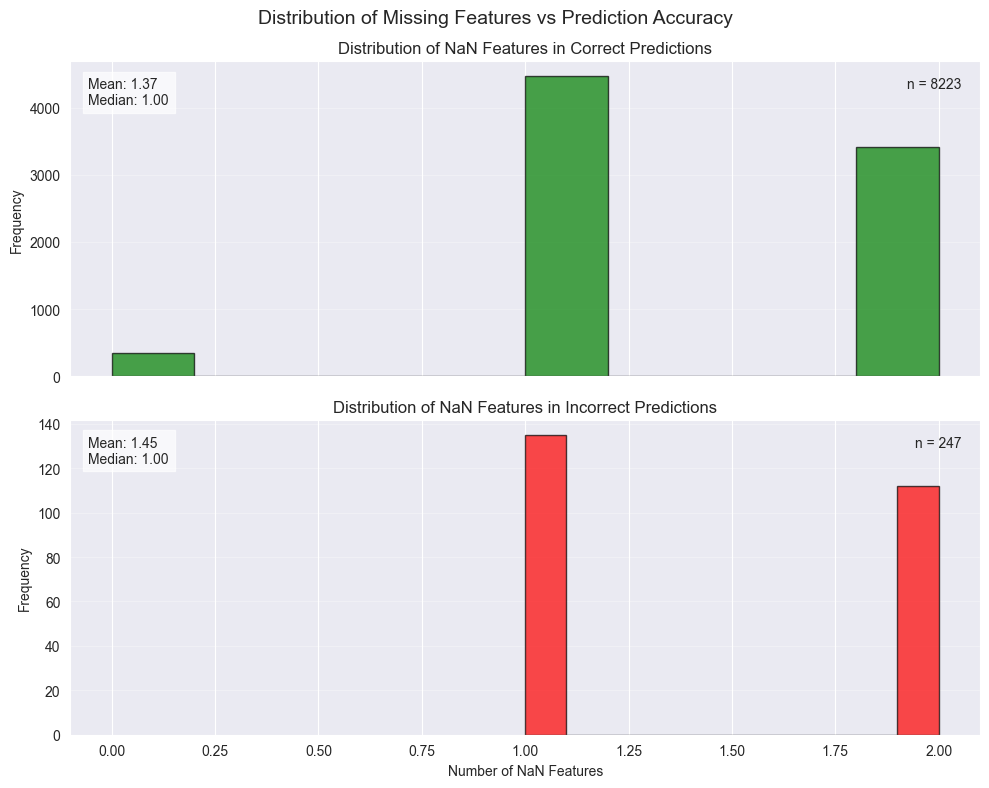

In [121]:
# Create a figure with 2 rows, 1 column
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plt.subplots_adjust(hspace=0.3)

# Get the min and max values across the entire dataset to use the same bins for both plots
min_nan = num_nans_in_error['num_nan_features'].min()
max_nan = num_nans_in_error['num_nan_features'].max()
num_bins = int(max_nan - min_nan) + 1  # +1 to ensure we capture all integer values
bins = np.arange(min_nan, max_nan + 2) - 0.5  # +2 and -0.5 for bin edges to center on integers

# Filter data for each case
correct_predictions = num_nans_in_error[num_nans_in_error['is_error'] == False]
error_predictions = num_nans_in_error[num_nans_in_error['is_error'] == True]

# Plot for correct predictions (is_error=False)
axes[0].hist(correct_predictions['num_nan_features'], color='green', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of NaN Features in Correct Predictions', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].text(0.98, 0.95, f'n = {len(correct_predictions)}',
             horizontalalignment='right', verticalalignment='top',
             transform=axes[0].transAxes, fontsize=10)

# Plot for incorrect predictions (is_error=True)
axes[1].hist(error_predictions['num_nan_features'], color='red', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of NaN Features in Incorrect Predictions', fontsize=12)
axes[1].set_xlabel('Number of NaN Features', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].text(0.98, 0.95, f'n = {len(error_predictions)}',
             horizontalalignment='right', verticalalignment='top',
             transform=axes[1].transAxes, fontsize=10)

# Add statistics to the plots
for i, data in enumerate([correct_predictions['num_nan_features'], error_predictions['num_nan_features']]):
    mean_val = data.mean()
    median_val = data.median()
    stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}'
    axes[i].text(0.02, 0.95, stats_text,
                 horizontalalignment='left', verticalalignment='top',
                 transform=axes[i].transAxes, fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.7))

# Set the same x-axis limits for both plots
max_freq = max(
    np.histogram(correct_predictions['num_nan_features'])[0].max(),
    np.histogram(error_predictions['num_nan_features'])[0].max()
)
plt.suptitle('Distribution of Missing Features vs Prediction Accuracy', fontsize=14)

plt.tight_layout()
plt.show()